# acta paper -- a bunch of simulations
This notebook generates data for the acta acustica paper.

In [1]:
import sparrowpy as sp
import pyfar as pf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
%matplotlib inline

font={
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 11,
}

plt.rcParams.update(font)

base_dir = os.path.join(os.getcwd(), "resources")

## Infinite diffuse plane

In [48]:
def run_energy_diff_specular_ratio(
        width, length, patch_size, source, receiver):
    """
    Calculate the ratio of diffuse to specular energy for an plane.
    The plane is located in the x-y plane. Its center is at (0, 0, 0).

    Parameters
    ----------
    width : float
        Width of the plane.
    length : float
        length of the plane.
    patch_size : float
        Size of the patches.
    source : pf.Coordinates
        Position of the source.
    receiver : pf.Coordinates
        Position of the receiver in cartesian.

    Returns
    -------
    ratio : float
        Ratio of diffuse to specular energy.
    """
    source_is = source.copy()
    source_is.z *= -1
    reflection_len =  (receiver - source_is).radius[0]
    speed_of_sound = 343
    sampling_rate = 1
    etc_duration = reflection_len/speed_of_sound
    etc_duration=1

    plane = sp.geometry.Polygon(
            [[-width/2, -length/2, 0],
             [width/2, -length/2, 0],
             [width/2, length/2, 0],
             [-width/2, length/2, 0]],
            [1, 0, 0], [0, 0, 1])

    #simulation parameters
    radi = sp.DirectionalRadiosityFast.from_polygon(
        [plane], patch_size)

    brdf_sources = pf.Coordinates(0, 0, 1, weights=1)
    brdf_receivers = pf.Coordinates(0, 0, 1, weights=1)
    brdf = sp.brdf.create_from_scattering(
        brdf_sources,
        brdf_receivers,
        pf.FrequencyData(1, [100]),
        pf.FrequencyData(0, [100]),
    )

    radi.set_wall_brdf(
        np.arange(1), brdf, brdf_sources, brdf_receivers)

    # set air absorption
    radi.set_air_attenuation(
        pf.FrequencyData(
            np.zeros_like(brdf.frequencies),
            brdf.frequencies))

    # initialize source energy at each patch
    radi.init_source_energy(source)

    # gather energy at receiver
    radi.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        etc_time_resolution=1/sampling_rate,
        etc_duration=etc_duration,
        max_reflection_order=0)

    I_diffuse = radi.collect_energy_receiver_mono(receiver)

    I_specular = 1/(4*np.pi*reflection_len**2)
    return np.sum(I_diffuse.time)/I_specular

run_energy_diff_specular_ratio(
        1, 1, 1, pf.Coordinates(0, 0, 2, weights=1), pf.Coordinates(0, 0, 2, weights=1))

0.28228890101400717

In [49]:
width=100
depth=100
patch_sizes = width/np.array([1,2,5,10,20,50,100,150])
theta_deg = np.arange(5,90,5)
theta = np.deg2rad(theta_deg)

col_names = ["patch_size",
             "col_raw", "col_abs","col_rel","col_rt",
             "dif_raw", "dif_abs","dif_rel","dif_rt"]

for th in theta_deg:
    col_names.append("var_raw_"+f'{th}')
    col_names.append("var_abs_"+f'{th}')
    col_names.append("var_rel_"+f'{th}')
    col_names.append("var_abs_"+f'{th}')

df = pd.DataFrame(columns=col_names)
df["patch_size"]=patch_sizes

In [50]:
ratio1=[]
t1=[]
# colocated s-r
source = pf.Coordinates(0, 0, 2, weights=1)
receiver = pf.Coordinates(0, 0, 2, weights=1)
for patch_size in patch_sizes:
    t0 = time.time()
    ratio1.append(run_energy_diff_specular_ratio(
        width, depth, patch_size, source, receiver))
    t1.append(time.time()-t0)

df["col_raw"] = ratio1
df["col_rt"] = t1
df["col_abs"] = 2-np.array(ratio1)
df["col_rel"] = 100*(2-np.array(ratio1))/2


KeyboardInterrupt: 

In [ ]:
err2 = []
ratio2=[]
t2=[]
# same normal
source = pf.Coordinates(0, 0, 1, weights=1)
receiver = pf.Coordinates(0, 0, 2, weights=1)
for patch_size in patch_sizes:
    print(patch_size)
    t0 = time.time()
    ratio2.append(run_energy_diff_specular_ratio(
        width, depth, patch_size, source, receiver))
    t2.append(time.time()-t0)

df["dif_raw"] = ratio2
df["dif_rt"] = t2
df["dif_abs"] = 2-np.array(ratio2)
df["dif_rel"] = 100*(2-np.array(ratio2))/2

100.0
50.0
20.0
10.0
5.0
2.0
1.0
0.5


In [ ]:
theta = np.deg2rad(np.arange(5,90,5))

for i, th in enumerate(theta):
    source = pf.Coordinates.from_spherical_colatitude(
        0, th, 2/np.cos(th), weights=1)
    receiver = pf.Coordinates.from_spherical_colatitude(
        np.pi, th, 2/np.cos(th), weights=1)
    t3=[]
    ratio3 = []
    for patch_size in patch_sizes:
        t0 = time.time()
        ratio3.append(run_energy_diff_specular_ratio(
            width, depth, patch_size, source, receiver))
        t3.append(time.time()-t0)
    df["var_raw_"+f"{theta_deg[i]}"] = ratio3
    df["var_rt_"+f"{theta_deg[i]}"] = t3
    df["var_abs_"+f"{theta_deg[i]}"] = 2*np.cos(th)-np.array(ratio3)
    df["var_rel_"+f"{theta_deg[i]}"] = 100*(2*np.cos(th) -
                                            np.array(ratio3))/(2*np.cos(th))



In [ ]:
df.to_csv(os.getcwd()+"/out/inf_plane_data.csv")

## Diffuse shoebox room

In [10]:
import json
def loadSceneProperties(scene_name = "seminar"):

    with open(os.path.join(base_dir,scene_name+"_scene.json")) as json_file:
        data = json.load(json_file)

    return data

raven_data = loadSceneProperties(scene_name = "diffuse_room")

In [11]:
ref_freq = 1000

def run_shoebox_sim(patch_size=1.,step = 1/1000,
                    scene=raven_data["scene_data"],
                    ref_freq = ref_freq):

    # Define parameters
    X = 5
    Y = 6
    Z = 4
    etc_duration = scene["etc_duration"]
    etc_time_resolution = step
    max_reflection_order = 150
    speed_of_sound = scene["sound_speed"]
    absorption = 0.1

    # create geometry
    walls = sp.testing.shoebox_room_stub(X, Y, Z)
    src = scene["source"]["position"]
    source = pf.Coordinates(src[0], src[1], src[2])
    rec = scene["receiver"]["position"]
    receiver = pf.Coordinates(rec[0], rec[1], rec[2])

    t0 = time.time()
    # create object
    radiosity_fast = sp.DirectionalRadiosityFast.from_polygon(walls,patch_size)
    # create directional scattering data (totally diffuse)
    brdf_sources = pf.Coordinates(0, 0, 1, weights=1)
    brdf_receivers = pf.Coordinates(0, 0, 1, weights=1)
    frequencies = np.array([ref_freq])
    brdf = sp.brdf.create_from_scattering(
        brdf_sources,
        brdf_receivers,
        pf.FrequencyData(np.ones_like(frequencies), frequencies),
        pf.FrequencyData(absorption*np.ones_like(frequencies), frequencies))

    # set directional scattering data
    radiosity_fast.set_wall_brdf(
        np.arange(len(walls)), brdf, brdf_sources, brdf_receivers)

    # set air absorption
    radiosity_fast.set_air_attenuation(
        pf.FrequencyData(
            np.zeros_like(brdf.frequencies),
            brdf.frequencies))

    # calculate from factors including brdfs
    radiosity_fast.bake_geometry()

    radiosity_fast.init_source_energy(source)

    radiosity_fast.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        etc_time_resolution=etc_time_resolution,
        etc_duration=etc_duration,
        max_reflection_order=max_reflection_order)

    etc_radiosity = radiosity_fast.collect_energy_receiver_mono(
    receivers=receiver)
    runtime = time.time()-t0

    return etc_radiosity.time[0,:,:], runtime, radiosity_fast.n_patches

run_shoebox_sim(step=.2)

C:\Users\jotag\AppData\Local\Temp\ipykernel_17340\390542449.py:38: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity_fast.set_wall_brdf(


(array([[0.        , 0.24714947, 0.        , 0.        , 0.        ]]),
 2.3758416175842285,
 148)

In [12]:
def calculate_RT30(curve,step):
    i0 = np.argmin(np.abs(10*np.log10(curve/np.max(curve))+5))
    i1 = np.argmin(np.abs(10*np.log10(curve/np.max(curve))+35))
    t0 = i0*step
    t1 = i1*step
    x0 = curve[i0]
    x1 = curve[i1]
    dB0 = 10*np.log10(x0)
    dB1 = 10*np.log10(x1)

    m = (dB1-dB0)/(t1-t0)

    RT30 = -60/m

    return RT30


In [13]:

## varying patch size
ps = .1
steps = np.array(raven_data["simu_output"]["step_size"])
sizes = 1/np.arange(1,3)
rt30 = []
curves = []
runtimes = []
stepsizes=[]
patchsizes=[]
npatches=[]
for ps in sizes:
    for step in steps:
        curve,rt,npa = run_shoebox_sim(patch_size=ps,step=step)
        rt30.append(calculate_RT30(curve=curve[0,:],step=step))
        curves.append(curve)
        stepsizes.append(step)
        patchsizes.append(ps)
        runtimes.append(rt)
        npatches.append(npa)

C:\Users\jotag\AppData\Local\Temp\ipykernel_17340\390542449.py:38: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity_fast.set_wall_brdf(


In [14]:
simu_dict = {"step_size": np.array(stepsizes),
             "curves": curves,
             "RT30": np.array(rt30),
             "runtime": np.array(runtimes),
             "patch_sizes": np.array(patchsizes),
             "resolution": np.array(npatches),
            }

pf.io.write(filename=os.getcwd()+"/out/diffuse_room_sparrow.far", compress=False, **simu_dict)

In [15]:
t = np.arange(0,raven_data["scene_data"]["etc_duration"],step)
X = 5
Y = 6
Z = 4
S = (2*X*Y) + (2*X*Z) + (2*Y*Z)
A = S*raven_data["scene_data"]["materials"]["abs20scat00"]["absorption"][0]
alpha_dash = A/S
r_h = 1/4*np.sqrt(A/np.pi)
print(f'reverberation distance is {r_h:.1f}m')
V = X*Y*Z
RT = 24*np.log(10)/(raven_data["scene_data"]["sound_speed"])*V/(-S*np.log(1-alpha_dash))
print(f'reverberation time is {RT:.2f}s')
E_reverb_analytical = 4/A

# Kuttruff Eq 4.7
w_0 = E_reverb_analytical/ V
t_0 = 0.03
# Kuttruff Eq 4.10
reverberation_analytic = w_0 * np.exp(+(
    raven_data["scene_data"]["sound_speed"]*S*np.log(1-alpha_dash)/(4*V))*(t-t_0))
reverberation_analytic = pf.TimeData(reverberation_analytic, t)

reverberation distance is 0.5m
reverberation time is 1.24s


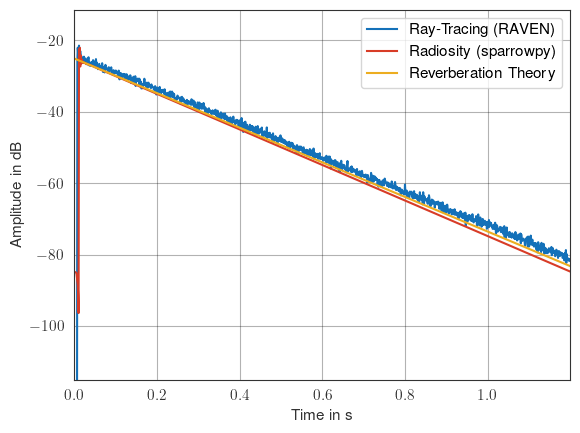

baba


In [ ]:
ind = np.where(np.array(raven_data["simu_output"]["step_size"])==step)[0]
ind = ind[np.where(np.array(raven_data["simu_output"]["resolution"])[ind]==1000)[0][0]]

freqbin = np.where(np.array(raven_data["scene_data"]["f"])==ref_freq)[0][0]
plt.figure()
rav = pf.TimeData(np.array(raven_data["simu_output"]["etc"][ind][freqbin]),t)
spa = pf.TimeData(curve[0], t)
pf.plot.time(rav,dB=True,log_prefix=10)
pf.plot.time(spa,dB=True,log_prefix=10)
pf.plot.time(reverberation_analytic,dB=True, log_prefix=10)
plt.legend(["Ray-Tracing (RAVEN)","Radiosity (sparrowpy)", "Reverberation Theory"])
plt.show()
print("baba")

In [17]:
%load_ext watermark
%watermark -v -m -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.1.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 68 Stepping 1, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

numpy     : 1.26.4
pyfar     : 0.7.2
json      : 2.0.9
sparrowpy : 0.1.0
pandas    : 2.3.0
matplotlib: 3.10.1

